# KDE demo, with histosys!

> It works :)

![](assets/kde_pyhf_animation.gif)

In [1]:
#!pip install neos matplotlib celluloid
#!pip install git+http://github.com/scikit-hep/pyhf.git@diffable_json

In [2]:
import time

import jax
import jax.experimental.optimizers as optimizers
import jax.experimental.stax as stax
import jax.random
from jax.random import PRNGKey
import numpy as np
from functools import partial

import pyhf
pyhf.set_backend('jax')
pyhf.default_backend = pyhf.tensor.jax_backend(precision='64b')

from neos import data, makers
from relaxed import infer

rng = PRNGKey(22)

/workspaces/relaxed/.venv/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
# regression net
init_random_params, predict = stax.serial(
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1),
    stax.Sigmoid,
)

## Compose differentiable workflow

In [4]:
dgen = data.generate_blobs(rng,blobs=4) 

# Specify our hyperparameters ahead of time for the kde histograms
bins = np.linspace(0,1,4)
bandwidth=0.27
reflect_infinite_bins = False
import jax.numpy as jnp
bins = jnp.array([-9999, *bins, 9999])
hmaker = makers.hists_from_nn(dgen, predict, hpar_dict = dict(bins=bins,bandwidth=bandwidth),method='kde', reflect_infinities=reflect_infinite_bins)

In [20]:
nnm = makers.histosys_model_from_hists(hmaker)
get_cls = infer.make_hypotest(nnm, solver_kwargs=dict(pdf_transform=False),metrics = ["CLs", "pull", "pull_err"])

# loss returns a list of metrics -- let's just index into one (CLs)
def loss(params):
    return get_cls(params, test_mu=1.0)["CLs"]

### Randomly initialise nn weights and check that we can get the gradient of the loss wrt nn params

In [47]:
nnm(network)[0].config.suggested_init()
#get_cls(network, test_mu=1.0)["pull"][0]

[1.0, 0.0]

In [22]:
_, network = init_random_params(jax.random.PRNGKey(2), (-1, 2))

# gradient wrt nn weights
jax.value_and_grad(loss)(network)

(DeviceArray(0.05980821, dtype=float64),
 [(DeviceArray([[-2.2057606e-05, -1.7633478e-04,  4.7349519e-04, ...,
                 -1.1183631e-04, -4.5881420e-04, -7.2723749e-05],
                [ 4.0431700e-05,  1.6405412e-04, -2.4578752e-04, ...,
                  1.2640976e-06,  3.1553293e-04,  1.4759413e-05]],            dtype=float32),
   DeviceArray([-4.49381832e-06,  1.08118675e-05,  2.77824060e-04, ...,
                 1.08441593e-04, -1.95847068e-04, -2.43451541e-05],            dtype=float32)),
  (),
  (DeviceArray([[ 2.4429724e-07,  3.9035353e-07,  1.3128692e-05, ...,
                  1.9822515e-08,  3.7728291e-06, -2.1114516e-07],
                [ 2.6211475e-07,  1.4920001e-07,  1.5212853e-05, ...,
                  1.2126484e-08,  4.5364886e-06, -1.2643795e-06],
                [-2.5073279e-08, -1.2743593e-05,  1.8078697e-06, ...,
                 -6.3305669e-07, -1.1739028e-05,  3.1692477e-06],
                ...,
                [ 4.9077528e-07,  4.1870089e-06,  2.4107

### Define training loop!

In [23]:
opt_init, opt_update, opt_params = optimizers.adam(1e-3)

def train_network(N):
    cls_vals = []
    _, network = init_random_params(jax.random.PRNGKey(1), (-1, 2))
    state = opt_init(network)
    losses = []

    # parameter update function
    # @jax.jit
    def update_and_value(i, opt_state, mu):
        net = opt_params(opt_state)
        value, grad = jax.value_and_grad(loss)(net)
        return opt_update(i, grad, state), value, net

    for i in range(N):
        start_time = time.time()
        state, value, network = update_and_value(i, state, 1.0)
        epoch_time = time.time() - start_time
        losses.append(value)
        metrs = get_cls(network, test_mu=1.0)
        metrics = {"loss": losses, "pull": metrs["pull"], "pull_err": metrs["pull_err"]}


        
        yield network, metrics, epoch_time

### Plotting helper function for awesome animations :)

In [39]:
def plot(axs, network, metrics, maxN):
    ax = axs["Data space"]
    g = np.mgrid[-5:5:101j, -5:5:101j]
    levels = bins[1:-1] # infinite
    ax.contourf(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, 1)[:, :, 0],
        levels=levels,
        cmap="binary",
    )
    ax.contour(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, 1)[:, :, 0],
        colors="w",
        levels=levels,
    )
    sig, bkg_nom, bkg_up, bkg_down = dgen()

    ax.scatter(sig[:, 0], sig[:, 1], alpha=0.3, c="C9")
    ax.scatter(bkg_up[:, 0], bkg_up[:, 1], alpha=0.1, c="C1", marker=6)
    ax.scatter(bkg_down[:, 0], bkg_down[:, 1], alpha=0.1, c="C1", marker=7)
    ax.scatter(bkg_nom[:, 0], bkg_nom[:, 1], alpha=0.3, c="C1")

    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    ax = axs["CLs per epoch"]
    # ax.axhline(0.05, c="slategray", linestyle="--")
    ax.plot(metrics["loss"], c="steelblue", linewidth=2.0)
    ax.set_yscale("log")
    #ax.set_ylim(1e-4, 0.06)
    ax.set_xlim(0, maxN)
    ax.set_xlabel("epoch")
    ax.set_ylabel(r"$CL_s$")
    
    ax = axs["Histogram model"]
    s, b, bup, bdown = hmaker(network)

    
    noinf = bins[1:-1]
    bin_width = 1 / (len(noinf) - 1)
    centers = noinf[:-1] + np.diff(noinf) / 2.0
    centers = jnp.array([noinf[0]-bin_width, *centers, noinf[-1]+bin_width])

    ax.bar(centers, b, color="C1", width=bin_width)
    ax.bar(centers, s, bottom=b, color="C9", width=bin_width)

    bunc = np.asarray([[x, y] if x > y else [y, x] for x, y in zip(bup, bdown)])
    plot_unc = []
    for unc, be in zip(bunc, b):
        if all(unc > be):
            plot_unc.append([max(unc), be])
        elif all(unc < be):
            plot_unc.append([be, min(unc)])
        else:
            plot_unc.append(unc)

    plot_unc = np.asarray(plot_unc)
    b_up, b_down = plot_unc[:, 0], plot_unc[:, 1]

    ax.bar(centers, bup - b, bottom=b, alpha=0.4, color="red", width=bin_width, hatch="+")
    ax.bar(
        centers, b - bdown, bottom=bdown, alpha=0.4, color="green", width=bin_width, hatch="-"
    )

    ax.set_ylim(0, 120)
    ax.set_ylabel("frequency")
    ax.set_xlabel("nn output")

    ax = axs["Nuisance pull"]

    pulls = metrics["pull"]
    pullerr = metrics["pull_err"]

    ax.set_ylabel(r"$(\theta - \hat{\theta})\,/ \Delta \theta$", fontsize=18)

    # draw the +/- 2.0 horizontal lines
    ax.hlines([-2, 2], -0.5, len(pulls) - 0.5, colors="black", linestyles="dotted")
    # draw the +/- 1.0 horizontal lines
    ax.hlines([-1, 1], -0.5, len(pulls) - 0.5, colors="black", linestyles="dashdot")
    # draw the +/- 2.0 sigma band
    ax.fill_between([-0.5, len(pulls) - 0.5], [-2, -2], [2, 2], facecolor="yellow")
    # drawe the +/- 1.0 sigma band
    ax.fill_between([-0.5, len(pulls) - 0.5], [-1, -1], [1, 1], facecolor="green")
    # draw a horizontal line at pull=0.0
    ax.hlines([0], -0.5, len(pulls) - 0.5, colors="black", linestyles="dashed")

    ax.scatter(range(len(pulls)), pulls, color="black")
    # and their uncertainties
    ax.errorbar(
        range(len(pulls)),
        pulls,
        color="black",
        xerr=0,
        yerr=pullerr[0],
        marker=".",
        fmt="none",
    )


### Let's run it!!

In [40]:
1+1

2

epoch 0: pull=[-0.01432809]+-[[0.92003195]] CLs = 0.05994020082331675, took 2.0408270359039307s


<ipython-input-39-6b39e846b278>:12: UserWarning: No contour levels were found within the data range.
  ax.contour(


epoch 1: pull=[2.35715712e-06]+-[[0.17334217]] CLs = 0.015429610142659422, took 2.9521756172180176s
epoch 2: pull=[2.0066248e-06]+-[[0.15291555]] CLs = 0.002202987518673538, took 2.94281005859375s
epoch 3: pull=[1.92407851e-06]+-[[0.1525673]] CLs = 0.0005034774086580818, took 3.034851551055908s
epoch 4: pull=[1.88634127e-06]+-[[0.15322746]] CLs = 0.0001975165976084714, took 2.9702675342559814s
epoch 5: pull=[1.86348768e-06]+-[[0.15384089]] CLs = 0.00010885887217404466, took 2.9370954036712646s
epoch 6: pull=[1.84819455e-06]+-[[0.15457642]] CLs = 7.333129398112703e-05, took 2.931208372116089s
epoch 7: pull=[1.83726284e-06]+-[[0.15545079]] CLs = 5.583187338964457e-05, took 2.923954725265503s
epoch 8: pull=[1.82925204e-06]+-[[0.15643467]] CLs = 4.598016054124798e-05, took 2.8996782302856445s
epoch 9: pull=[1.82356633e-06]+-[[0.15749669]] CLs = 3.98825595981922e-05, took 2.924038887023926s
epoch 10: pull=[1.81987072e-06]+-[[0.15862488]] CLs = 3.581892423909494e-05, took 2.959113597869873s


PermissionError: [Errno 13] Permission denied: 'animationinfesoft.gif'

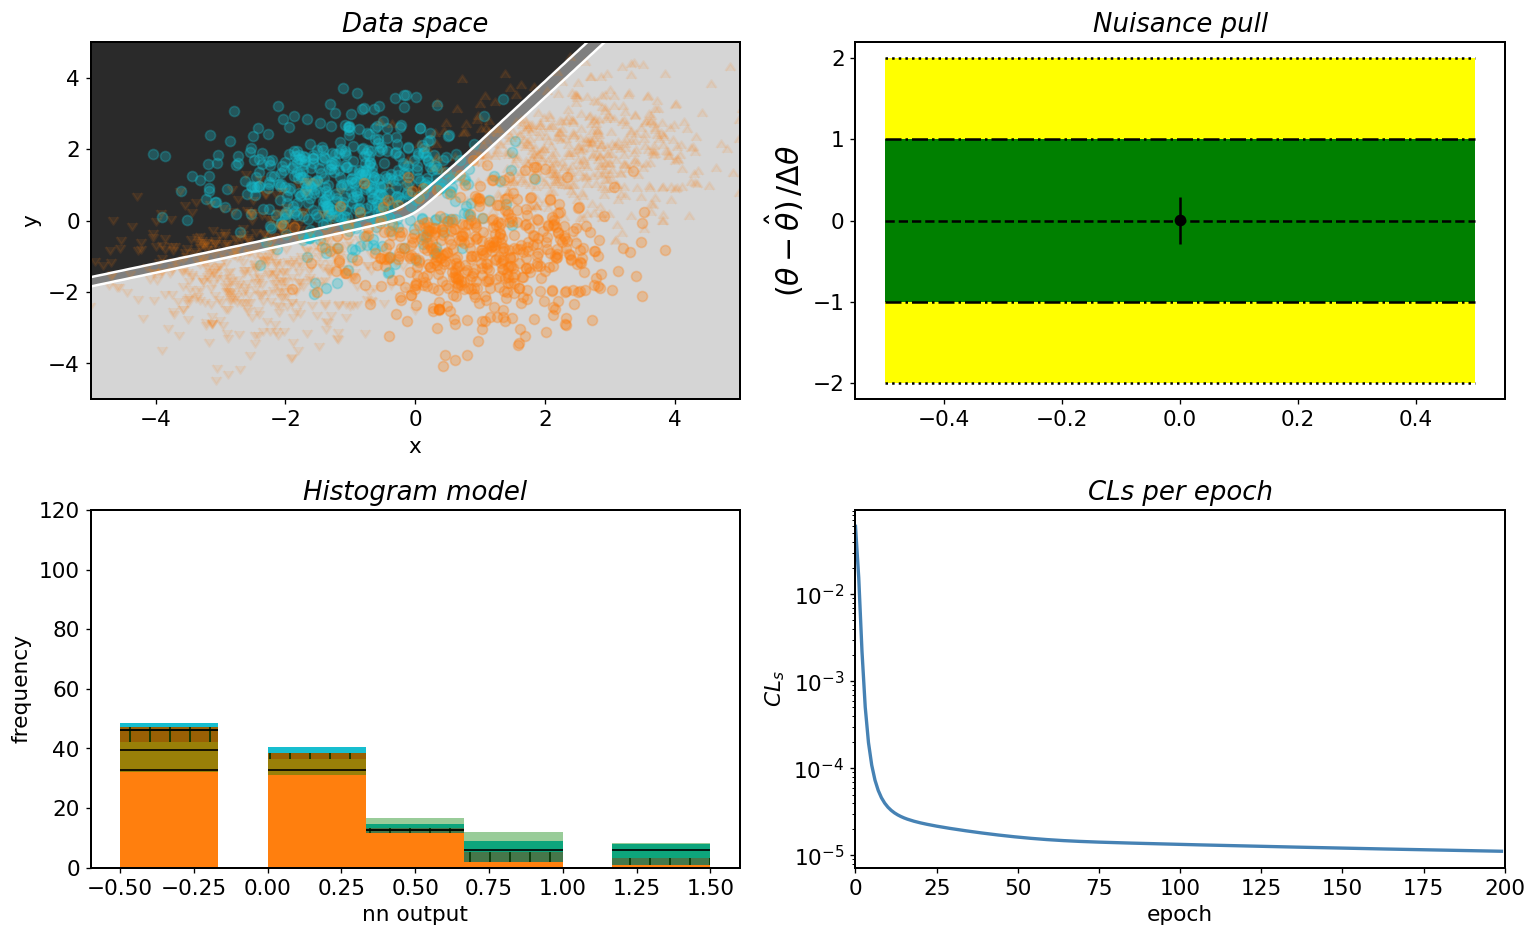

In [45]:
# slow
import numpy as np
from IPython.display import HTML

from matplotlib import pyplot as plt

plt.rcParams.update(
    {
        "axes.labelsize": 13,
        "axes.linewidth": 1.2,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "figure.figsize": [13.0, 8.0],
        "font.size": 13,
        "xtick.major.size": 3,
        "ytick.major.size": 3,
        "legend.fontsize": 11,
    }
)

plt.rc("figure", dpi=120)

fig, axs = plt.subplot_mosaic(
    [["Data space", "Nuisance pull"], ["Histogram model", "CLs per epoch"]]
)

for label, ax in axs.items():
    ax.set_title(label, fontstyle="italic")

maxN = 200# make me bigger for better results!

animate = True  # animations fail tests...
ax_cpy = axs
if animate:
    from celluloid import Camera

    camera = Camera(fig)

# Training
for i, (network, metrics, epoch_time) in enumerate(train_network(maxN)):
    print(f"epoch {i}:", f'pull={metrics["pull"]}+-{metrics["pull_err"]}', f'CLs = {metrics["loss"][-1]}, took {epoch_time}s')
    if animate:
        plot(axs, network, metrics, maxN=maxN)
        plt.tight_layout()
        camera.snap()
        axs = ax_cpy
        # if i % 10 == 0:
        #     camera.animate().save("animation.gif", writer="imagemagick", fps=8)
            # HTML(camera.animate().to_html5_video())
    # break
if animate:
    camera.animate().save("animationinfesoft.gif", writer="imagemagick", fps=10)

In [ ]:
1

In [32]:
from IPython.display import HTML
animation = camera.animate()
HTML(animation.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available

In [46]:
camera.animate().save("/workspaces/relaxed/afast.gif", writer="imagemagick", fps=13)